# CART, Logistic Regression and Random Forest

<p>The following notebook provides an example code of predicting whether <b>the client will subscribe to a term deposit or not </b> using Decision Tree classification.
The dependent variable is <b>Y (subscribing the term deposit) (1-"Yes", 0-"No")</b>. The aim is to practice sklearn framework using Logistic Regression, Decision Tree and Random Forest Classificaiton algorithms in the analysis. 
    
<br>The general sequence of steps for the analysis the following:
1. [Descriptive analysis](#pandas)
2. [Fully grown Decision Tree (w/o GridSearchCV)](#stats)
3. [Tuned Decision Tree, Logistic Regression and Random Forest based on best hyperparameters](#stats1)
4. [Decision Tree, Logistic Regression and Random Forest results comparison](#stats2)
5. [ROC Curve, Gain and Lift charts for winning model](#stats4)

 <h2>1.Descriptive analysis</h2> <a name="pandas"></a>

The initial data consists of 4119 observations of 21 variables. There are no duplicates, missing values and variables with single value for all observations.
As the main models to be used are a non-parametric (DT and RF), we are not going to dive deep into the correlations and data manipulation as we used to do. 
Deposit subscription is not evenly balanced between 0s and 1s. As the countplot and value counts show, only about 11% of employees are subscribing and ~89% are not. So we can use this info as a naive assumption for newcomers to decide whether they'll leave or stay. In other words, if the resulting score is more than the noted value, then our model will be not bad, otherwise-a bad one. 

In [1]:
#data manipulation and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

#libraries for modelling and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve
import scikitplot as skplt #in case of error run "pip install scikit-plot" in cmd(terminal) and run the code again
#for not showing warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing the data and making a dataframe
url="https://raw.githubusercontent.com/srbuhimirzoyan/Business_Analytics_Spring2020/master/Session_8_Banking_data.csv"
data=pd.read_csv(url)

In [3]:
#data overview
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
age               4119 non-null int64
job               4119 non-null object
marital           4119 non-null object
education         4119 non-null object
default           4119 non-null object
housing           4119 non-null object
loan              4119 non-null object
contact           4119 non-null object
month             4119 non-null object
day_of_week       4119 non-null object
duration          4119 non-null int64
campaign          4119 non-null int64
pdays             4119 non-null int64
previous          4119 non-null int64
poutcome          4119 non-null object
emp_var_rate      4119 non-null float64
cons_price_idx    4119 non-null float64
cons_conf_idx     4119 non-null float64
euribor3m         4119 non-null float64
nr_employed       4119 non-null float64
y                 4119 non-null int64
dtypes: float64(5), int64(6), object(10)
memory usage: 675.9+ KB


In [4]:
#have a look at first rows of the dataframe
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,30,blue_collar,married,basic_9y,no,yes,no,cellular,may,fri,...,2,0,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high_school,no,no,no,telephone,may,fri,...,4,0,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high_school,no,yes,no,telephone,jun,wed,...,1,0,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,married,basic_9y,no,unknown,unknown,telephone,jun,fri,...,3,0,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin_,married,university_degree,no,yes,no,cellular,nov,mon,...,1,0,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


In [5]:
data.describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,0.227725,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695,0.109493
std,10.313362,254.703736,2.568159,1.369053,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904,0.312294
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000,0.000000
25%,32.000000,103.000000,1.000000,0.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000,0.000000
50%,38.000000,181.000000,2.000000,0.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.000000,317.000000,3.000000,0.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,88.000000,3643.000000,35.000000,21.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [6]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:",data.duplicated().sum())
print("Missing values:",data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 0
Missing values: 0
Single valued columns: Index([], dtype='object')


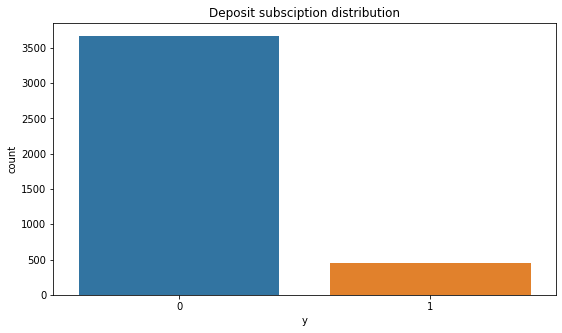

In [7]:
#let's visualise the distribution of y
plt.figure(figsize=(9,5))
sns.countplot(data.y)
plt.title("Deposit subsciption distribution")
plt.show()

In [8]:
#lets count the benchmark for deposit subscription distribution
data.y.value_counts(normalize=True).mul(100).rename("Deposit subscription distribution")

0    89.05074
1    10.94926
Name: Deposit subscription distribution, dtype: float64

 <h2>2.Fully grown Decision Tree (w/o GridSearchCV)</h2> <a name="stats"></a>

We decided first to run model on without tuning any hyperparameter to see its performance. On the fully grown DT we got 1 and 0.73 ROC AUC scores on train and test sets, respectively. This means that our model is overfitting. Therefore,the next step would be hyperparameter tuning (simplifying the tree by pruning peripheral branches to avoid overfitting).

In [9]:
#making dummes,separating X and Y, train test split
data=pd.get_dummies(data,drop_first=True)

X=data.drop('y', axis=1)
Y=data.y

In [10]:
X0, X1, Y0, Y1=train_test_split(X,Y, test_size=0.25, random_state=42)

In [11]:
#building DT with default hyperparameters
dt=DecisionTreeClassifier(random_state=42)
dt.fit(X0,Y0)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [12]:
#calculating probabilities
Y0_dt=dt.predict_proba(X0)[:,1]
Y1_dt=dt.predict_proba(X1)[:,1]

In [13]:
#printing the ROC AUC scores for training and testing sets
print("ROC_AUC Train for fully grown DT:",roc_auc_score(Y0,Y0_dt))
print("ROC_AUC Test for fully grown DT:",roc_auc_score(Y1,Y1_dt).round(2))

ROC_AUC Train for fully grown DT: 1.0
ROC_AUC Test for fully grown DT: 0.73


<h2> Tuned Decision Tree, Logistic Regression and Random Forest based on best hyperparameters</h2> <a name="stats1"></a>

In order to improve our results, let's use GridSearch for hyperparameter tuning and see which model outperforms others based on mean cross-validated ROC AUC score.

##### Decision Tree Classifier

In [14]:
#setting up parameters for DT's GridSearch
param_dt={"max_depth":range(1,15),
          "min_samples_leaf":range(10,150,10),
          "class_weight":["balanced",None]        
            }

In [15]:
#fitting GridSearch with above specified parameters
gs_dt=GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_dt,
                  scoring="roc_auc",cv=5)
gs_dt.fit(X0,Y0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': range(1, 15),
                         

In [16]:
gs_dt.best_params_

{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 30}

In [17]:
#fitting the model with best parameters
dt_grid=DecisionTreeClassifier(class_weight='balanced',max_depth=5,min_samples_leaf=30, random_state=42).fit(X0,Y0)

In [18]:
Y0_dt_grid=dt_grid.predict_proba(X0)[:,1]
Y1_dt_grid=dt_grid.predict_proba(X1)[:,1]
print("ROC_AUC Train for tuned DT:",roc_auc_score(Y0,Y0_dt_grid).round(2))
print("ROC_AUC Test for tuned DT:",roc_auc_score(Y1,Y1_dt_grid).round(2))
print("Mean 5-fold ROC AUC score for Tuned DT",np.mean(cross_val_score(estimator=dt_grid,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))

ROC_AUC Train for tuned DT: 0.95
ROC_AUC Test for tuned DT: 0.92
Mean 5-fold ROC AUC score for Tuned DT 0.92


##### Logistic Regression

In [19]:
#building GridSearch with Logistic Regression
logit=LogisticRegression(random_state=42)

param_logit={"class_weight":["balanced",None],
            "C":np.linspace(0.0001,50,20)}


gs_logit=GridSearchCV(estimator=logit,
                      param_grid=param_logit,
                      scoring="roc_auc", cv=5, verbose=1, n_jobs=2).fit(X0,Y0)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.5s
[Parallel(n_jobs=2)]: Done 197 out of 200 | elapsed:   15.2s remaining:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:   15.3s finished


In [20]:
#finding out the best parameters
gs_logit.best_params_

{'C': 2.631673684210526, 'class_weight': 'balanced'}

In [21]:
#building logit with best params and seeing the results
logit_grid=LogisticRegression(C=2.631673684210526,class_weight='balanced',random_state=42).fit(X0,Y0)

Y0_logit=logit_grid.predict_proba(X0)[:,1]
Y1_logit=logit_grid.predict_proba(X1)[:,1]
print("ROC_AUC Train for tuned Logit:",roc_auc_score(Y0,Y0_logit).round(2))
print("ROC_AUC Test for tuned Logit:",roc_auc_score(Y1,Y1_logit).round(2))
print("Mean 5-fold ROC AUC score for Tuned Logit",np.mean(cross_val_score(estimator=logit_grid,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))

ROC_AUC Train for tuned Logit: 0.95
ROC_AUC Test for tuned Logit: 0.93
Mean 5-fold ROC AUC score for Tuned Logit 0.93


##### Random Forest Classifier

As Random Forest uses the same hyperparameters as Decision Tree, for parameters grid in GridSearch we will use already defined `param_dt`

In [24]:
print(param_dt)

{'max_depth': range(1, 15), 'min_samples_leaf': range(10, 150, 10), 'class_weight': ['balanced', None]}


In [25]:
#building GridSearch for RF using DT's hyperparameters ranges
gs_rf=GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                  param_grid=param_dt, scoring="roc_auc", cv=3, n_jobs=2).fit(X0,Y0)

In [26]:
#outlining best parameters
gs_rf.best_params_

{'class_weight': None, 'max_depth': 9, 'min_samples_leaf': 20}

In [27]:
#building RF with the best parameters
rf_grid=RandomForestClassifier(class_weight=None,max_depth=9,min_samples_leaf=20, random_state=42).fit(X0,Y0)

Y0_rf_grid=rf_grid.predict_proba(X0)[:,1]
Y1_rf_grid=rf_grid.predict_proba(X1)[:,1]
print("ROC_AUC Train for tuned Logit:",roc_auc_score(Y0,Y0_rf_grid).round(2))
print("ROC_AUC Test for tuned Logit:",roc_auc_score(Y1,Y1_rf_grid).round(2))
print("Mean 5-fold ROC AUC score for Tuned RF",np.mean(cross_val_score(estimator=rf_grid,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))

ROC_AUC Train for tuned Logit: 0.95
ROC_AUC Test for tuned Logit: 0.91
Mean 5-fold ROC AUC score for Tuned RF 0.92


<h2>Decision Tree, Logistic Regression and Random Forest results comparison</h2> <a name="stats2"></a>


In [28]:
#As we see, Logistic Regression outperforms the two other models on mean 5-fold cross validation score.

print("Mean 5-fold ROC AUC score for Tuned DT",np.mean(cross_val_score(estimator=dt_grid,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))
print("Mean 5-fold ROC AUC score for Tuned RF",np.mean(cross_val_score(estimator=rf_grid,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))
print("Mean 5-fold ROC AUC score for Tuned Logit",np.mean(cross_val_score(estimator=logit_grid,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))

Mean 5-fold ROC AUC score for Tuned DT 0.92
Mean 5-fold ROC AUC score for Tuned RF 0.92
Mean 5-fold ROC AUC score for Tuned Logit 0.93


<h2>ROC Curve, Gain and Lift charts for winning model</h2> <a name="stats4"></a>

In [29]:
#setting up the needed metrics
FPR, TPR, thresholds=roc_curve(Y1, logit_grid.predict_proba(X1)[:,1])

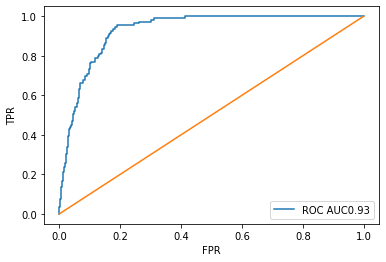

In [30]:
#plotting ROC AUC for Logistic Regression
plt.plot(FPR, TPR, label=f"ROC AUC{roc_auc_score(Y1,logit_grid.predict_proba(X1)[:,1]).round(2)}")
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [31]:
# Also we will plot gain and lift curve plots for the Logistic Regression

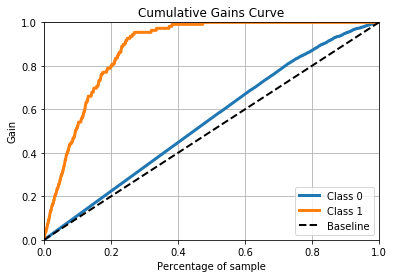

In [32]:
skplt.metrics.plot_cumulative_gain(Y1,logit_grid.predict_proba(X1))
plt.show()

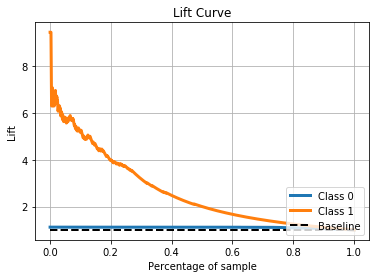

In [33]:
skplt.metrics.plot_lift_curve(Y1,logit_grid.predict_proba(X1))
plt.show()